In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler

# Plot configurations
% matplotlib inline

In [2]:
us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO',
                   'Connecticut': 'CT','Delaware': 'DE','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID',
                   'Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
                   'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
                   'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
                   'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC',
                   'North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA',
                   'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX',
                   'Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV',
                   'Wisconsin': 'WI','Wyoming': 'WY'}

# Load and Pre-process Data

In [3]:
warehouses = pd.read_csv("Data/CSV/amazon_labelled_locations.csv")
moodys = pd.read_csv("Data/CSV/MoodysData-ACS.csv")

# Drop some columns we don't need, drop rows with that we know we don't have data for
moodys = moodys.drop("Unnamed: 0", axis=1)
moodys = moodys.drop("Code", axis=1)
moodys = moodys.drop("Include in Amazon Dataset", axis=1)
moodys = moodys.drop("Current Senior Most Rating*", axis=1)
moodys = moodys.drop("Tax Backed Rating Description", axis=1)
moodys = moodys.drop("No. Persons/Household (ACS Data)", axis=1)
cols = list(moodys.columns)
cols[0] = "County"
cols[1] = "Year"
moodys.columns = cols
moodys = moodys[moodys.Year.between(2012, 2015, inclusive=True)].reset_index(drop=True)
moodys = moodys[moodys.County != "Median"]
moodys = moodys.apply(pd.to_numeric, errors="ignore", downcast="float")
moodys.County = map(lambda x: x[0], moodys.County.str.split(','))

metrics = cols[3:]
for metric in metrics:
    if metric not in ["No. Persons/Household (ACS Data)","Median Age (ACS Data)","% Below Poverty Level (ACS Data)"]:
        moodys[metric] = pd.to_numeric(moodys[metric].str.replace(",",""))

warehouses["State"] = map(lambda x: us_state_abbrev[x], warehouses["State"])
eligible_warehouses = warehouses[np.logical_or(warehouses.Year == 2013, warehouses.Year == 2014)]
counties_with_warehouses = eligible_warehouses[["State", "County"]].drop_duplicates().reset_index(drop=True)

In [4]:
metrics

['Population (ACS Data)',
 'Per Capita Income  (ACS Data)',
 'Median Family Income  (ACS Data)',
 'Median Home Value (ACS Data)',
 'Median Gross Rent (ACS Data)',
 'Occupied Housing Units (ACS Data)',
 'Seasonal Homes (ACS Data)',
 'Median Age (ACS Data)',
 '% Below Poverty Level (ACS Data)']

In [5]:
moodys_2012 = moodys[moodys.Year == 2012].drop("Year", axis=1).reset_index(drop=True)
moodys_2013 = moodys[moodys.Year == 2013].drop("Year", axis=1).reset_index(drop=True)
moodys_2014 = moodys[moodys.Year == 2014].drop("Year", axis=1).reset_index(drop=True)
moodys_2015 = moodys[moodys.Year == 2015].drop("Year", axis=1).reset_index(drop=True)

# Amazon Counties vs. All Counties

In [6]:
joined_all_counties = moodys_2012.merge(moodys_2015, on=["County", "State"], suffixes=('_2012', '_2015'))
joined_amazon_counties = joined_all_counties.merge(counties_with_warehouses, on=["County", "State"])

In [7]:
def plot_histograms(df1, df2, bins1, bins2, title, cutoff=.15, all_counties=True):
    f, ax = plt.subplots(1,2, figsize=(14,6))
    df1[df1.between(-cutoff, cutoff)].hist(bins=bins1, ax=ax[0])
    df2[df2.between(-cutoff, cutoff)].hist(bins=bins2, ax=ax[1])
    f.suptitle(title, fontsize=16, fontweight="bold")
    if all_counties:
        ax[0].set_title("All Counties")
    else:
        ax[0].set_title('Match Counties')
    ax[1].set_title("Counties with a warehouse built in 2013 or 2014")
    ax[0].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    ax[1].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

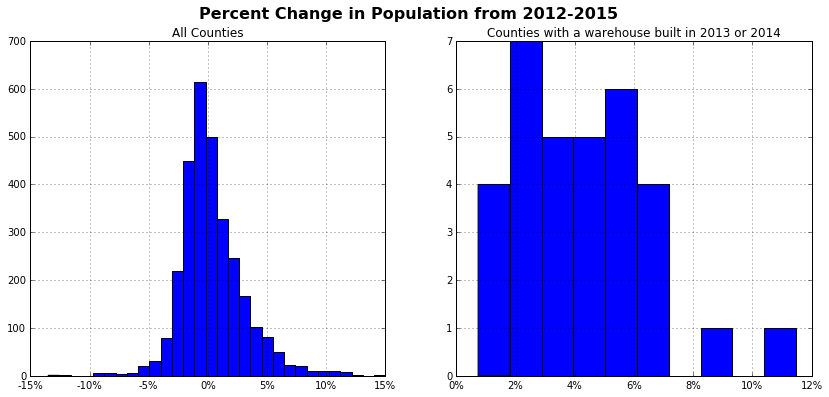

In [8]:
pop_percent_change = ((joined_all_counties["Population (ACS Data)_2015"] -
 joined_all_counties["Population (ACS Data)_2012"]) / 
 joined_all_counties["Population (ACS Data)_2012"])

pop_percent_change_amazon = ((joined_amazon_counties["Population (ACS Data)_2015"] -
 joined_amazon_counties["Population (ACS Data)_2012"]) /
 joined_amazon_counties["Population (ACS Data)_2012"])

plot_histograms(pop_percent_change, pop_percent_change_amazon, 30, 10, "Percent Change in Population from 2012-2015")

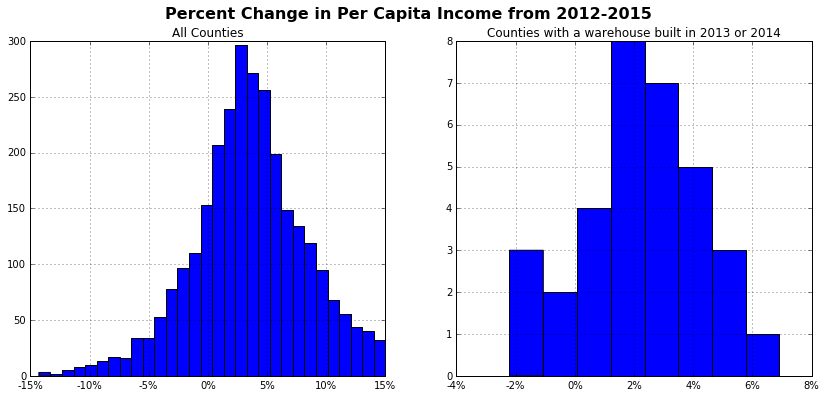

In [9]:
percap_income_change = ((joined_all_counties["Per Capita Income  (ACS Data)_2015"] -
joined_all_counties["Per Capita Income  (ACS Data)_2012"]) /
joined_all_counties["Per Capita Income  (ACS Data)_2012"])

percap_income_change_amazon = ((joined_amazon_counties["Per Capita Income  (ACS Data)_2015"] -
joined_amazon_counties["Per Capita Income  (ACS Data)_2012"]) /
joined_amazon_counties["Per Capita Income  (ACS Data)_2012"])

plot_histograms(percap_income_change, percap_income_change_amazon, 30,8,
                "Percent Change in Per Capita Income from 2012-2015")

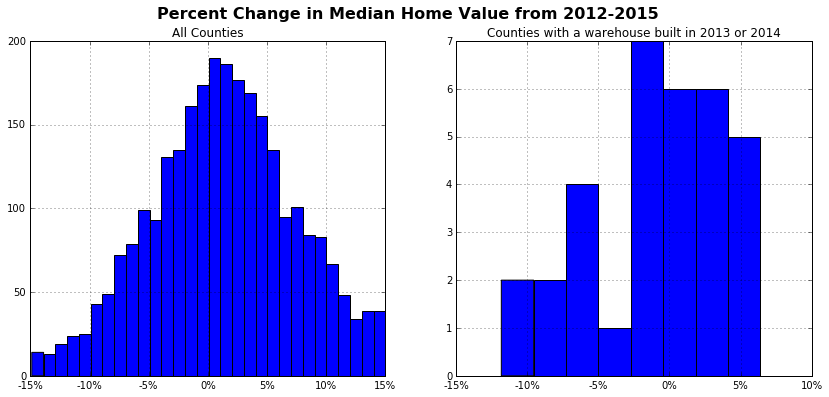

In [10]:
home_value_change = ((joined_all_counties["Median Home Value (ACS Data)_2015"] -
 joined_all_counties["Median Home Value (ACS Data)_2012"]) /
 joined_all_counties["Median Home Value (ACS Data)_2012"])

home_value_change_amazon = ((joined_amazon_counties["Median Home Value (ACS Data)_2015"] -
 joined_amazon_counties["Median Home Value (ACS Data)_2012"]) /
 joined_amazon_counties["Median Home Value (ACS Data)_2012"])

plot_histograms(home_value_change, home_value_change_amazon, 30, 8, "Percent Change in Median Home Value from 2012-2015")

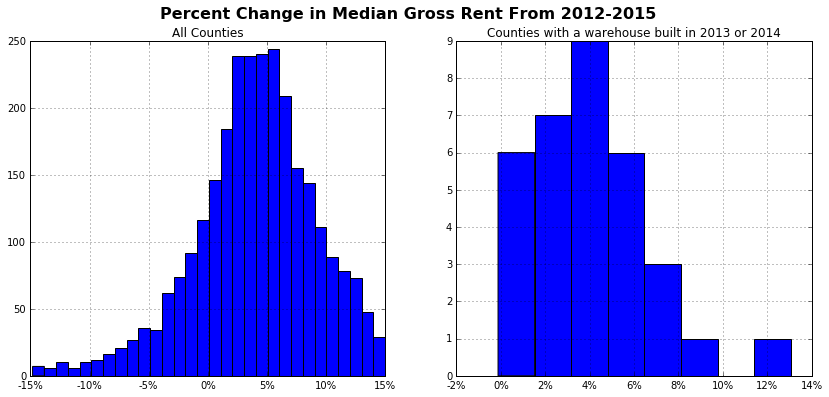

In [11]:
rent_percent_change = ((joined_all_counties["Median Gross Rent (ACS Data)_2015"] -
 joined_all_counties["Median Gross Rent (ACS Data)_2012"]) /
 joined_all_counties["Median Gross Rent (ACS Data)_2012"])

rent_percent_change_amazon = ((joined_amazon_counties["Median Gross Rent (ACS Data)_2015"] -
 joined_amazon_counties["Median Gross Rent (ACS Data)_2012"]) /
 joined_amazon_counties["Median Gross Rent (ACS Data)_2012"])

plot_histograms(rent_percent_change, rent_percent_change_amazon, 30, 8, "Percent Change in Median Gross Rent From 2012-2015")

# Amazon Counties vs. Similar Non-Amazon Counties

In [12]:
scaler = StandardScaler()

scaled_joined_all_counties = joined_all_counties.dropna().reset_index(drop=True)
scaled_joined_all_counties.iloc[:, 2:] = scaler.fit_transform(scaled_joined_all_counties.iloc[:, 2:].copy())

counties_with_warehouses_dummy = counties_with_warehouses.copy()
counties_with_warehouses_dummy["dummy"] = 0
scaled_all_counties_dummy = scaled_joined_all_counties.merge(counties_with_warehouses_dummy, on=["State","County"], how="left")
scaled_non_amazon_counties = scaled_all_counties_dummy[scaled_all_counties_dummy.dummy.isnull()].reset_index(drop=True).drop("dummy", axis=1)
scaled_amazon_counties = scaled_all_counties_dummy[scaled_all_counties_dummy.dummy.notnull()].reset_index(drop=True).drop("dummy", axis=1)

In [13]:
matches = pd.DataFrame({"WH_State": scaled_amazon_counties.State, "WH_County": scaled_amazon_counties.County})
non_WH_State = []
non_WH_County = []
for _, row in scaled_amazon_counties.iterrows():
    distances = np.linalg.norm(scaled_non_amazon_counties.iloc[:,2:].subtract(row.iloc[2:]).astype(float), axis=1)
    match_county, match_state = scaled_non_amazon_counties.iloc[np.argmin(distances)][['County','State']]
    non_WH_State.append(match_state)
    non_WH_County.append(match_county)

matches['Non_WH_County'] = non_WH_County
matches['Non_WH_State'] = non_WH_State

In [14]:
matches

,WH_County,WH_State,Non_WH_County,Non_WH_State
0,Alameda County,CA,Middlesex County,MA
1,Boone County,IN,Platte County,MO
2,Boone County,KY,Grundy County,IL
3,Bullitt County,KY,Christian County,MO
4,Cabarrus County,NC,York County,SC
5,Cumberland County,PA,Medina County,OH
6,Dallas County,TX,Wayne County,MI
7,Dauphin County,PA,Lexington County,SC
8,Fulton County,GA,Travis County,TX
9,Gloucester County,NJ,McHenry County,IL


In [15]:
joined_match_counties = joined_all_counties.merge(matches, left_on=['State', 'County'], right_on=['Non_WH_State', 'Non_WH_County'])

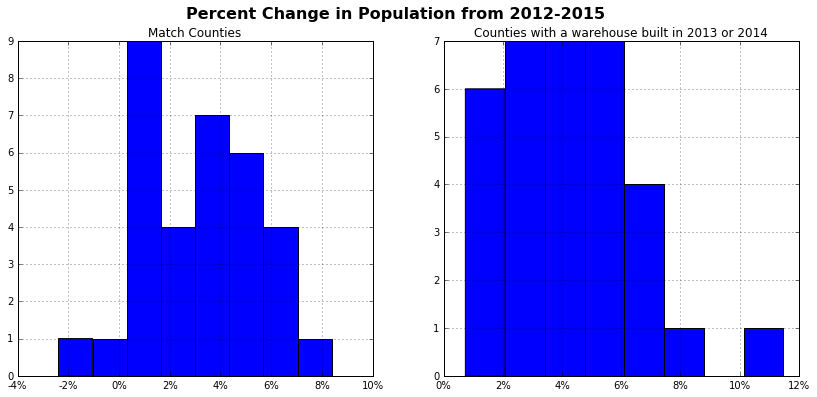

In [16]:
match_pop_percent_change = ((joined_match_counties["Population (ACS Data)_2015"] -
 joined_match_counties["Population (ACS Data)_2012"]) / 
 joined_match_counties["Population (ACS Data)_2012"])

pop_percent_change_amazon = ((joined_amazon_counties["Population (ACS Data)_2015"] -
 joined_amazon_counties["Population (ACS Data)_2012"]) /
 joined_amazon_counties["Population (ACS Data)_2012"])

plot_histograms(match_pop_percent_change, pop_percent_change_amazon, 8,8, "Percent Change in Population from 2012-2015", all_counties=False)

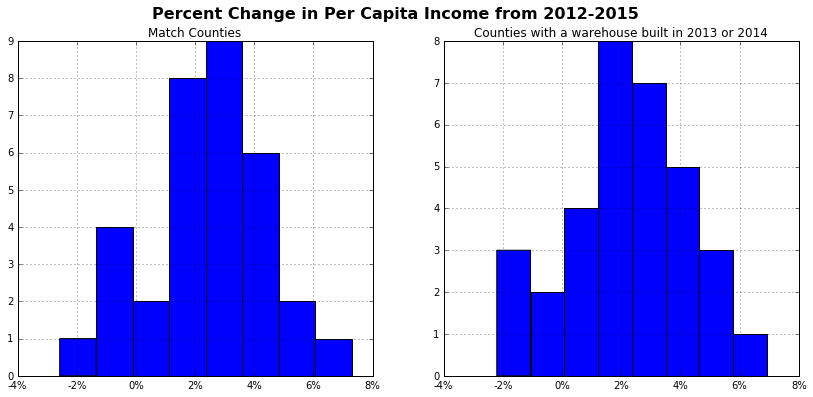

In [17]:
match_percap_income_change = ((joined_match_counties["Per Capita Income  (ACS Data)_2015"] -
joined_match_counties["Per Capita Income  (ACS Data)_2012"]) /
joined_match_counties["Per Capita Income  (ACS Data)_2012"])

percap_income_change_amazon = ((joined_amazon_counties["Per Capita Income  (ACS Data)_2015"] -
joined_amazon_counties["Per Capita Income  (ACS Data)_2012"]) /
joined_amazon_counties["Per Capita Income  (ACS Data)_2012"])

plot_histograms(match_percap_income_change, percap_income_change_amazon, 8,8,
                "Percent Change in Per Capita Income from 2012-2015", cutoff=.2, all_counties=False)

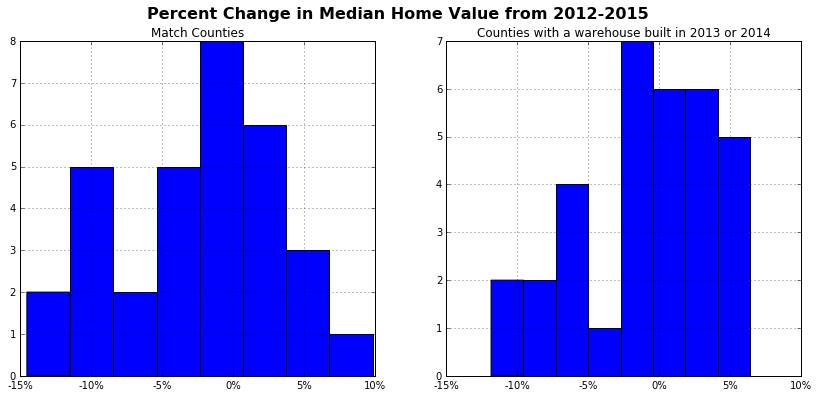

In [18]:
match_home_value_change = ((joined_match_counties["Median Home Value (ACS Data)_2015"] -
 joined_match_counties["Median Home Value (ACS Data)_2012"]) /
 joined_match_counties["Median Home Value (ACS Data)_2012"])

home_value_change_amazon = ((joined_amazon_counties["Median Home Value (ACS Data)_2015"] -
 joined_amazon_counties["Median Home Value (ACS Data)_2012"]) /
 joined_amazon_counties["Median Home Value (ACS Data)_2012"])

plot_histograms(match_home_value_change, home_value_change_amazon, 8, 8, "Percent Change in Median Home Value from 2012-2015", all_counties=False)

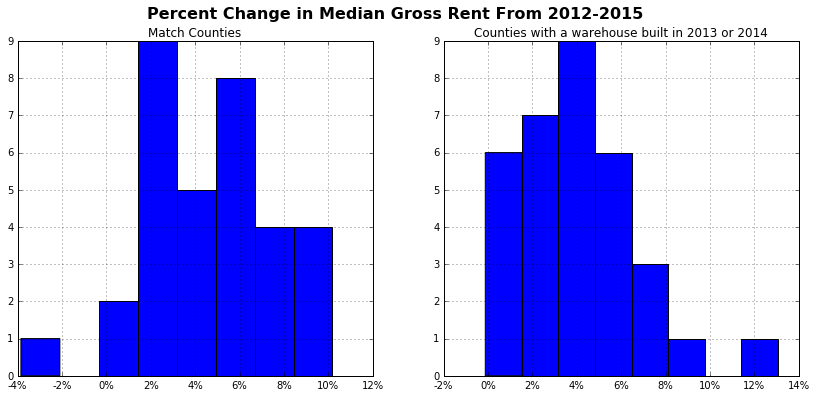

In [19]:
match_rent_percent_change = ((joined_match_counties["Median Gross Rent (ACS Data)_2015"] -
 joined_match_counties["Median Gross Rent (ACS Data)_2012"]) /
 joined_match_counties["Median Gross Rent (ACS Data)_2012"])

rent_percent_change_amazon = ((joined_amazon_counties["Median Gross Rent (ACS Data)_2015"] -
 joined_amazon_counties["Median Gross Rent (ACS Data)_2012"]) /
 joined_amazon_counties["Median Gross Rent (ACS Data)_2012"])

plot_histograms(match_rent_percent_change, rent_percent_change_amazon, 8, 8, "Percent Change in Median Gross Rent From 2012-2015", all_counties=False)

In [20]:
match_warehouses = matches.merge(warehouses, left_on=['Non_WH_State', 'Non_WH_County'], right_on=['State','County'])[['State','County','Year']]

In [29]:
gb = match_warehouses.groupby(by=['State','County']).count()
print(gb.shape[0], matches.shape[0])
print(gb)

(14, 33)
                        Year
State County                
CA    Orange County        5
CO    Adams County         8
IL    Cook County          6
MA    Middlesex County     4
MD    Harford County       1
MI    Wayne County         3
MN    Dakota County        1
NJ    Bergen County        2
NV    Clark County         4
NY    Nassau County        1
OH    Franklin County      2
SC    Lexington County     2
TX    Bexar County         2
      Travis County        2


In [26]:
match_warehouses.Year.value_counts()

2015.0    17
2016.0    13
2017.0     8
2018.0     3
2008.0     1
2011.0     1
Name: Year, dtype: int64